In [7]:
from dotenv import load_dotenv
load_dotenv()
import os
fred_api_key = os.getenv(".env")
import fredapi as fr
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from src.config import load_config
from src.logger import logger
from src.data import Fred_Data
from sklearn.metrics import root_mean_squared_error,r2_score
config = load_config()
fred_data = Fred_Data(api_key=fred_api_key,series_ids=config['series_ids'])
fred_data = fred_data.fetch_data()
df = fred_data.get_dataframe()
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)





cuda:0


In [8]:
"""USD/EURO"""

df = df['USDEURO']
df.drop_duplicates(inplace=True)
df = df.reset_index()
df['Date'] = df['index']
df.drop('index',axis=1,inplace=True)

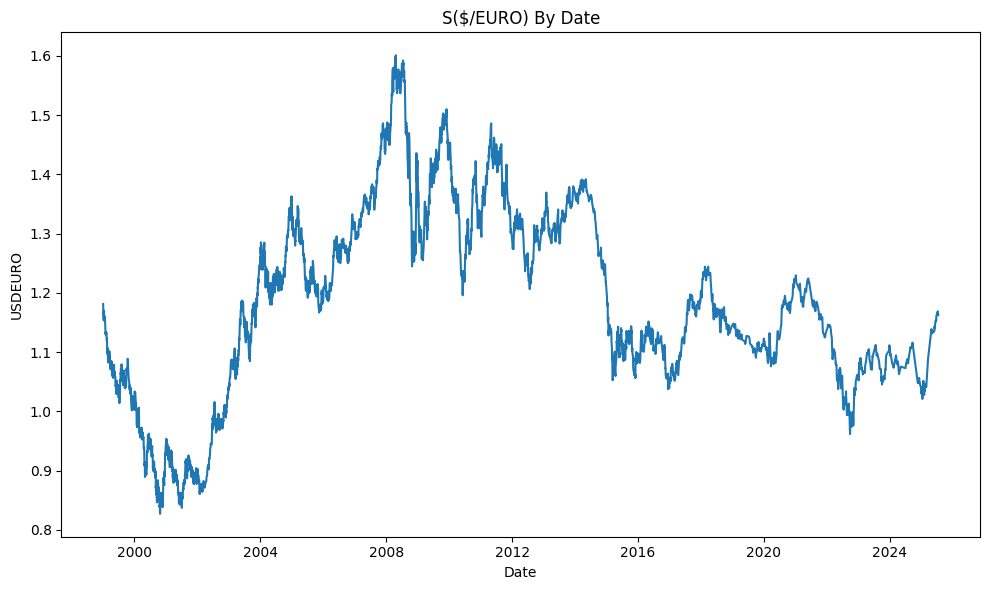

In [9]:
plt.figure(figsize=(10,6))
sns.lineplot(x='Date',y='USDEURO',data=df)
plt.title("S($/EURO) By Date")
plt.savefig("images/spotrate_S_usd_euro.png")
plt.tight_layout()
plt.show()


In [10]:

training = df.iloc[:,0:1].values
train_size = int(len(training) * .90)


train_data = training[:train_size]
test_data = training[train_size:]


scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)







def slider(data,seq_length):
    X,y = [],[]
    for i in range(len(data) - seq_length - 1):
        Xi = data[i:(i+seq_length)]
        yi = data[(i+seq_length)]
        X.append(Xi)
        y.append(yi)
        
    return np.array(X),np.array(y)

seq_length = 7

X_train,y_train = slider(train_scaled,seq_length)
X_test,y_test = slider(test_scaled,seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()


class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        h0 = torch.zeros(1, X.size(0), self.hidden_size)
        out, _ = self.gru(X, h0)
        out = self.fc(out[:,-1,:])
        return out



input_size = 1
hidden_size = 256
num_layers = 1
output_size = 1

model = GRU(input_size, hidden_size, num_layers, output_size)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
loss_fn = nn.MSELoss()
epochs = 500

for epoch in range(epochs):
    y_pred = model(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rsme = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  model(X_test)
        test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RSEM: {train_rsme:.4}; Test RSME: {test_rsme:.4}')






C:\Users\katsa\AppData\Local\Temp\ipykernel_15672\1224940217.py:80: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rsme = np.sqrt(loss_fn(y_pred,y_train))
C:\Users\katsa\AppData\Local\Temp\ipykernel_15672\1224940217.py:82: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RSEM: 0.4377; Test RSME: 0.2646
Epoch: 1; train_RSEM: 0.3806; Test RSME: 0.2077
Epoch: 2; train_RSEM: 0.3233; Test RSME: 0.1506
Epoch: 3; train_RSEM: 0.2661; Test RSME: 0.09718
Epoch: 4; train_RSEM: 0.2133; Test RSME: 0.07355
Epoch: 5; train_RSEM: 0.1793; Test RSME: 0.1183
Epoch: 6; train_RSEM: 0.187; Test RSME: 0.1938
Epoch: 7; train_RSEM: 0.2208; Test RSME: 0.2559
Epoch: 8; train_RSEM: 0.2351; Test RSME: 0.2762
Epoch: 9; train_RSEM: 0.2233; Test RSME: 0.2612
Epoch: 10; train_RSEM: 0.1988; Test RSME: 0.2268
Epoch: 11; train_RSEM: 0.1754; Test RSME: 0.1858
Epoch: 12; train_RSEM: 0.1615; Test RSME: 0.1467
Epoch: 13; train_RSEM: 0.1584; Test RSME: 0.1141
Epoch: 14; train_RSEM: 0.1619; Test RSME: 0.09039
Epoch: 15; train_RSEM: 0.1671; Test RSME: 0.07551
Epoch: 16; train_RSEM: 0.1706; Test RSME: 0.06761
Epoch: 17; train_RSEM: 0.1709; Test RSME: 0.06389
Epoch: 18; train_RSEM: 0.1673; Test RSME: 0.06234
Epoch: 19; train_RSEM: 0.1601; Test RSME: 0.06252
Epoch: 20; train_RSEM: 

In [13]:
with torch.no_grad():
    pred = model(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)


rmse = root_mean_squared_error(y_test_np,pred_np)
r2 = r2_score(y_test_np,pred_np)
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2*100:.2f}%')


test_dates = df.iloc[train_size + seq_length: -1]['Date'].reset_index(drop=True)

comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Spot Rate": actual_rescaled.flatten(),
    "Predicted Spot Rate": pred_rescaled.flatten()
})

print(comparison_df.head(20))
print(comparison_df.tail(20))

RMSE: 0.020104961469769478
R2 Score: 94.76%
         Date  Actual Spot Rate  Predicted Spot Rate
0  2020-04-22            1.0829             1.092858
1  2020-04-24            1.0798             1.089023
2  2020-04-28            1.0836             1.085133
3  2020-04-29            1.0853             1.083941
4  2020-05-01            1.0998             1.084231
5  2020-05-05            1.0844             1.086747
6  2020-05-15            1.0816             1.087138
7  2020-05-22            1.0894             1.086638
8  2020-05-26            1.0970             1.087077
9  2020-05-27            1.0969             1.089076
10 2020-05-28            1.1069             1.091173
11 2020-06-09            1.1348             1.094849
12 2020-06-10            1.1355             1.102908
13 2020-06-12            1.1253             1.112217
14 2020-06-16            1.1259             1.118739
15 2020-06-17            1.1219             1.122960
16 2020-06-24            1.1272             1.124620
17

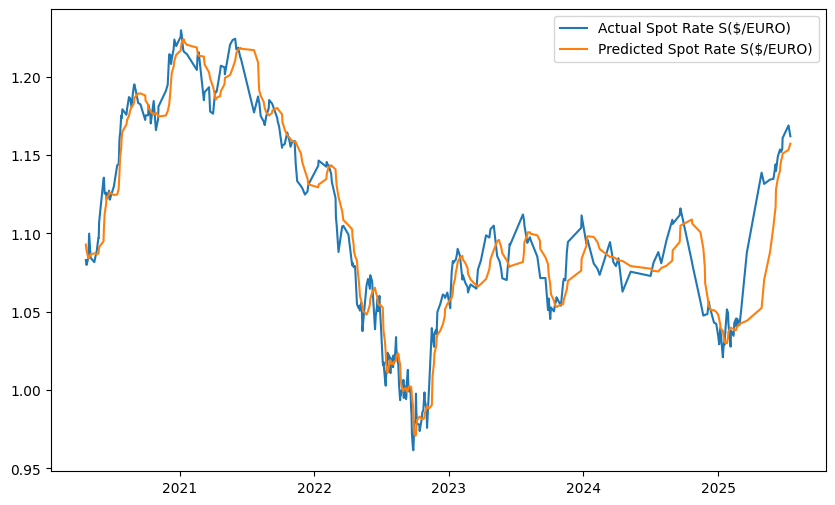

In [14]:
plt.figure(figsize=(10,6))
plt.plot(comparison_df['Date'],comparison_df["Actual Spot Rate"],label="Actual Spot Rate S($/EURO)")
plt.plot(comparison_df['Date'],comparison_df['Predicted Spot Rate'],label="Predicted Spot Rate S($/EURO)")
plt.legend()
plt.savefig("images/predicted_vs_actual_SpotRate.png")
plt.show()